In [25]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


# - Manejo de Datos

## -- Datos de entrenamiento

In [2]:
data=pd.read_csv("dataset/train.csv",sep=",")
data["date"]=pd.to_datetime(data["date"])
data_exogen = data.copy()
data=data.set_index("date")
data.head()
data

,substation,consumption
date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [3]:
data.describe()

,consumption
count,244391.000000
mean,179.548024
std,156.018729
min,-199.000000
25%,0.181926
50%,172.099977
75%,262.179646
max,752.006309


In [4]:
# Separamos el dataset en las distintas subestaciones

for substation in data['substation'].unique():
    
    globals()[f"data_{substation}"] = data['consumption'][data['substation'] == substation]    
    globals()[f"data_{substation}"] = globals()[f"data_{substation}"].resample('h').interpolate()

    globals()[f"data_exogen_{substation}"] = data_exogen[data_exogen['substation'] == substation].copy()
    # globals()[f"data_exogen_{substation}"] = globals()[f"data_exogen_{substation}"].resample('h').interpolate()

    

In [5]:
# Revisamos si el dataset tiene valores nulos o NaN (Not a Number)
print("Datos NaN:", len(data_AJAHUEL[data_AJAHUEL.isna()==True]),"- Datos Nulos:", len(data_AJAHUEL[data_AJAHUEL.isnull() == True]))


Datos NaN: 0 - Datos Nulos: 0


In [6]:
data_AJAHUEL.info()
#data_agrupada = data_agrupada.groupby(['fecha'], as_index=True)['consumption'].sum()

<class 'pandas.core.series.Series'>
DatetimeIndex: 35064 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: h
Series name: consumption
Non-Null Count  Dtype  
--------------  -----  
35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


In [7]:
# Calcular el rango intercuartílico (IQR) para detectar outliers
Q1 = data_AJAHUEL.quantile(0.25)
Q3 = data_AJAHUEL.quantile(0.75)
IQR = Q3 - Q1

# Definir los límites de detección de outliers (rango intercuartil)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = (data_AJAHUEL < lower_bound) | (data_AJAHUEL > upper_bound)

mean_data_AJAHUEL= data_AJAHUEL.mean()

if data_AJAHUEL[outliers].count():
    data_AJAHUEL[outliers] = mean_data_AJAHUEL


## -- Análisis datos entrenamiento

C:\Users\schavezh\AppData\Local\Temp\ipykernel_29592\1448264984.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);


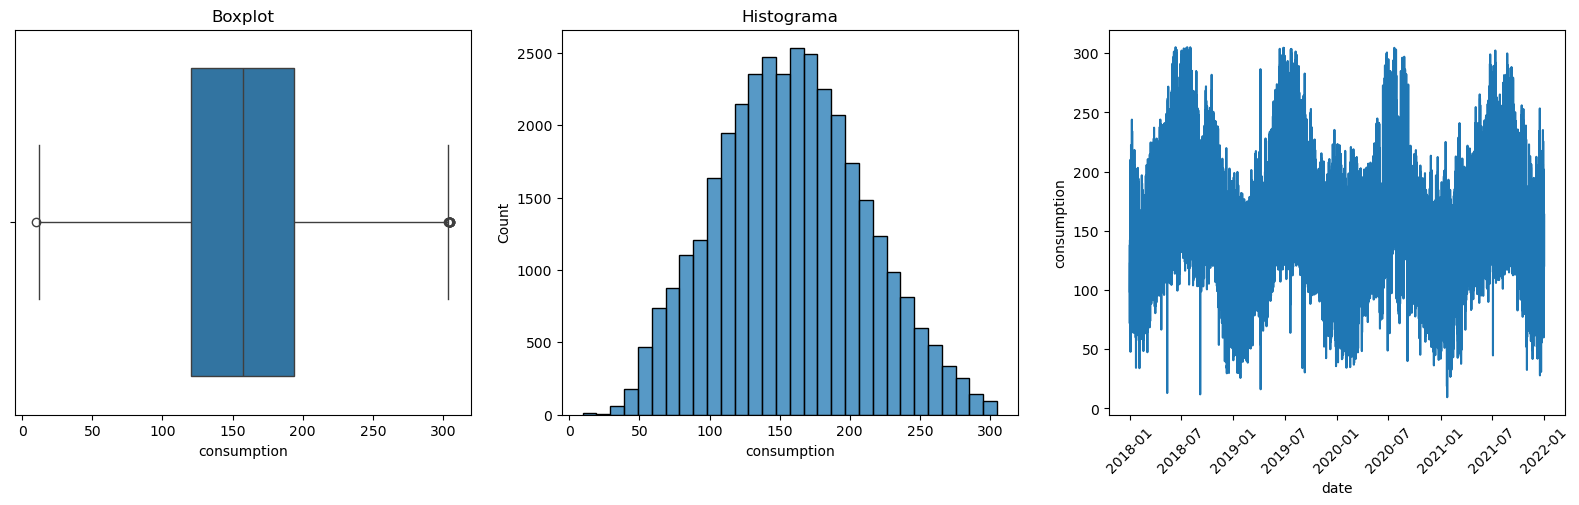

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
x_analisis = data_AJAHUEL[:]
fig, axes=plt.subplots(1,3)
fig.set_size_inches(20,5)

axes[0].set_title('Boxplot')
sns.boxplot(ax=axes[0], x=x_analisis)

axes[1].set_title('Histograma')
sns.histplot(ax=axes[1], x=x_analisis,  bins=30)


my_plot = sns.lineplot(ax=axes[2], y = x_analisis, x=x_analisis.index);
#rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);

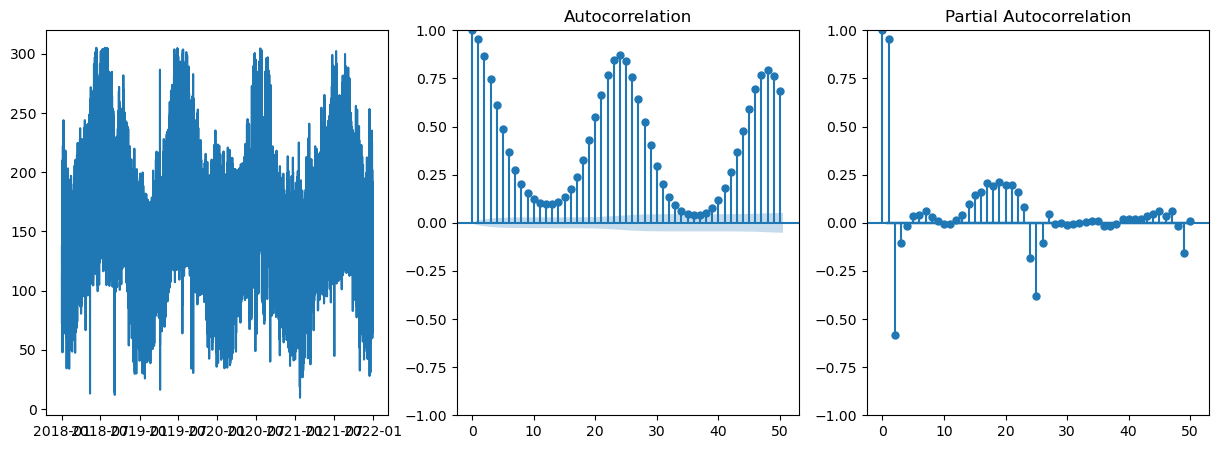

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 

fig, axes=plt.subplots(1,3)
fig.set_size_inches(15,5)
axes[0].plot(data_AJAHUEL.index,data_AJAHUEL)
plot_acf(data_AJAHUEL,lags=50,ax=axes[1]);
plot_pacf(data_AJAHUEL,lags=50,ax=axes[2]);

<Axes: xlabel='y(t)', ylabel='y(t + 48)'>

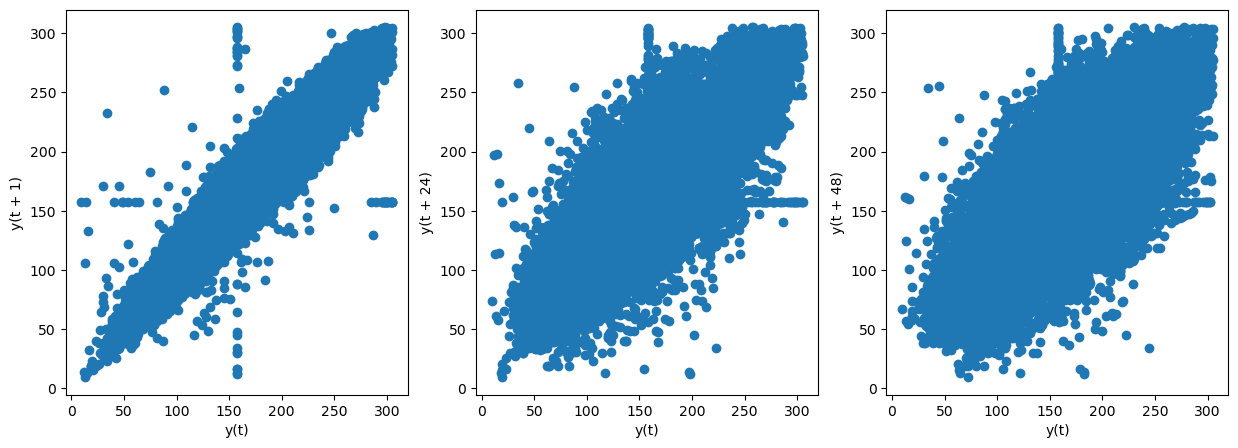

In [10]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 5)
pd.plotting.lag_plot(data_AJAHUEL, lag=1,ax=axes[0])
pd.plotting.lag_plot(data_AJAHUEL, lag=24,ax=axes[1])
pd.plotting.lag_plot(data_AJAHUEL, lag=48,ax=axes[2])

14.430184369224552


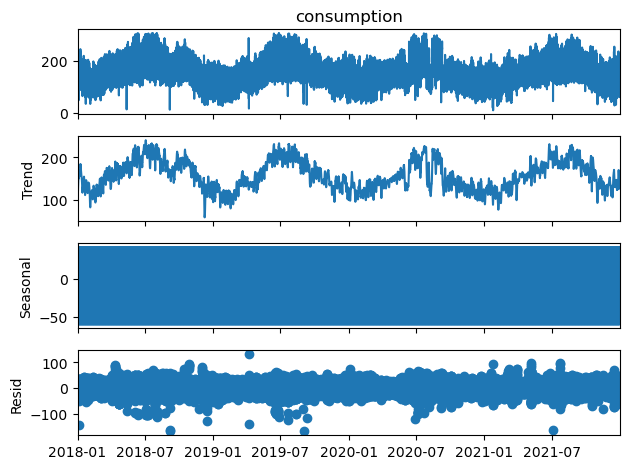

In [11]:
result=seasonal_decompose(data_AJAHUEL,model="additive",period=48);
promedio_abs_error = abs(result.resid).mean();
result.plot();
print(promedio_abs_error)

In [12]:
# Revisamos mediante el test adfuller si nuestros datos son estacionarios.
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_AJAHUEL,maxlag=1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -54.020093
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## -- Datos de test

In [13]:
data_test=pd.read_csv("dataset/test.csv",sep=",")
#data.info()
data_test["date"]=pd.to_datetime(data_test["date"])
data_test=data_test.set_index("date")
data_test.head()

,substation,consumption
date,,
2022-01-01 00:00:00,AJAHUEL,102.093131
2022-01-01 01:00:00,AJAHUEL,82.379086
2022-01-01 02:00:00,AJAHUEL,75.126780
2022-01-01 03:00:00,AJAHUEL,69.140084
2022-01-01 04:00:00,AJAHUEL,66.442176


In [14]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61313 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   substation   61313 non-null  object 
 1   consumption  61313 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [15]:
for substation in data_test['substation'].unique():
    globals()[f"data_test_{substation}"] = data_test['consumption'][data_test['substation'] == substation]
    globals()[f"data_test_{substation}"] = globals()[f"data_test_{substation}"].resample('h').interpolate()

# - Código

## -- SARIMA

### --- SARIMA 48 horas

In [254]:
# Ajustamos el modelo SARIMA con una ventana de 48

sarima_model_48 = SARIMAX(endog=data_AJAHUEL, order=(1, 0, 1), seasonal_order=(1, 1, 1, 48))
sarima_result_48 = sarima_model_48.fit(disp=False)

In [255]:
#Predecir los valores con SARIMA
sarima_pred_train_48 = sarima_result_48.predict(start=0, end=len(data_AJAHUEL)-1, typ='levels')

In [256]:
# Predecir también para el conjunto de test
sarima_pred_test_48 = sarima_result_48.predict(start=len(data_AJAHUEL), end=len(data_AJAHUEL) + len(data_test_AJAHUEL) - 1)

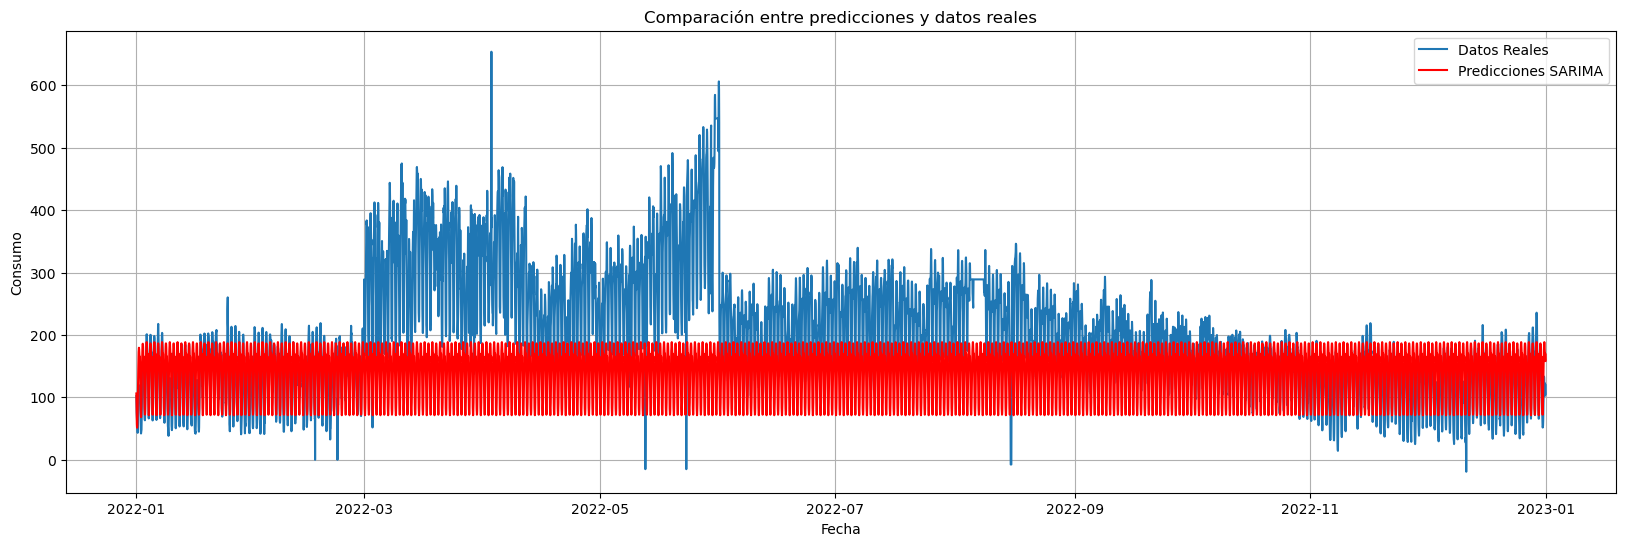

Mean Squared Error (MSE): 10999.957692708369
Root Mean Squared Error (RMSE): 104.88068312472211
Mean Absolute Error (MAE): 77.00960233719218
Mean Absolute Percentage Error (MAPE): 90988775590171.56
R-squared (R2): -0.250005244110556


In [257]:
plt.figure(figsize=(20, 6))
plt.plot(data_test_AJAHUEL.index,data_test_AJAHUEL, label='Datos Reales')
plt.plot(sarima_pred_test_48.index, sarima_pred_test_48, label='Predicciones SARIMA', color='red')
plt.title('Comparación entre predicciones y datos reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# Calcula las métricas

mse_samira_48 = mean_squared_error(data_test_AJAHUEL, sarima_pred_test_48)
rmse_sarimna_48 = np.sqrt(mse_samira_48)
mae_sarima_48 = mean_absolute_error(data_test_AJAHUEL, sarima_pred_test_48)
mape_sarima_48 = mean_absolute_percentage_error(data_test_AJAHUEL[:], sarima_pred_test_48[:])
r2_sarima_48 = r2_score(data_test_AJAHUEL[:], sarima_pred_test_48[:])

print(f"Mean Squared Error (MSE): {mse_samira_48}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarimna_48}")
print(f"Mean Absolute Error (MAE): {mae_sarima_48}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima_48}")
print(f"R-squared (R2): {r2_sarima_48}")

### --- SARIMA 24 horas

In [237]:
# Ajustamos el modelo SARIMA con una ventana de 24

sarima_model_24 = SARIMAX(endog=data_AJAHUEL, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
sarima_result_24 = sarima_model_24.fit(disp=False)

In [251]:
# sarima_model_24=[]
# sarima_result_24 = []


In [239]:
#Predecir los valores con SARIMA
sarima_pred_train_24 = sarima_result_24.predict(start=0, end=len(data_AJAHUEL)-1, typ='levels')

In [240]:
# Predecir también para el conjunto de test
sarima_pred_test_24 = sarima_result_24.predict(start=len(data_AJAHUEL), end=len(data_AJAHUEL) + len(data_test_AJAHUEL) - 1)

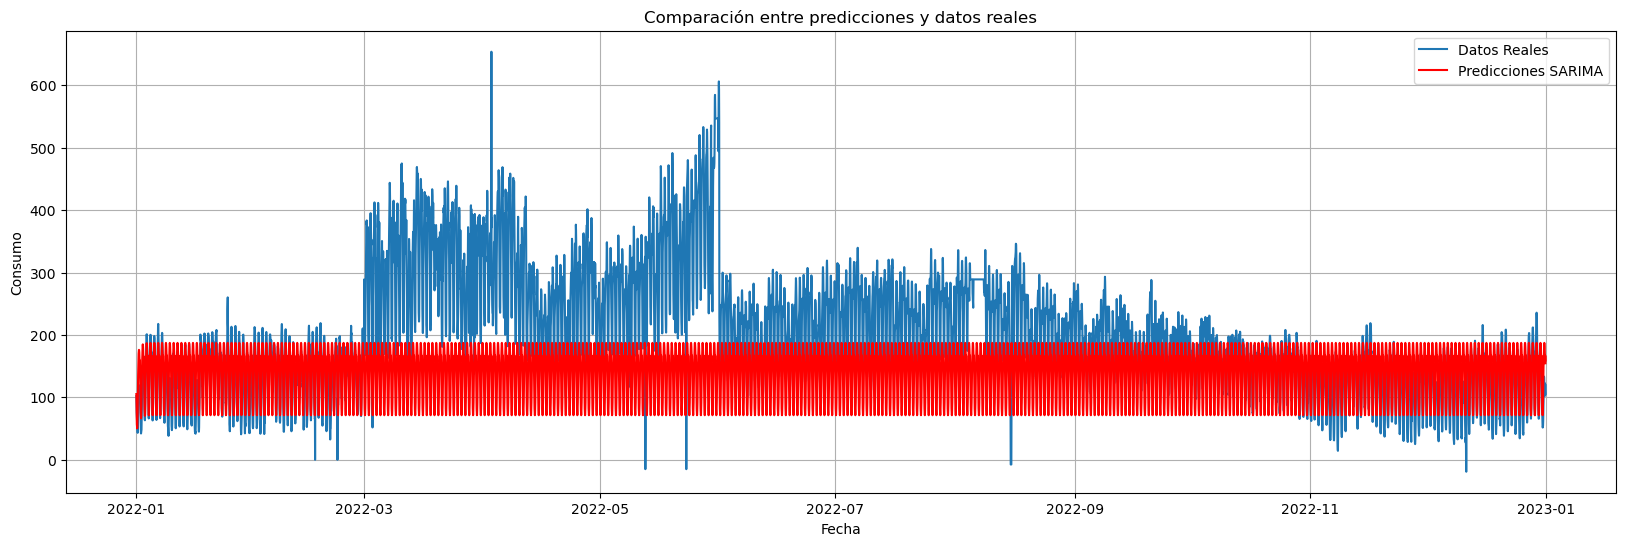

Mean Squared Error (MSE): 11043.545974613624
Root Mean Squared Error (RMSE): 105.0882770560714
Mean Absolute Error (MAE): 77.13974456221803
Mean Absolute Percentage Error (MAPE): 90571525100771.5
R-squared (R2): -0.25488798105332977


In [241]:
plt.figure(figsize=(20, 6))
plt.plot(data_test_AJAHUEL.index,data_test_AJAHUEL, label='Datos Reales')
plt.plot(sarima_pred_test_24.index, sarima_pred_test_24, label='Predicciones SARIMA', color='red')
plt.title('Comparación entre predicciones y datos reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# Calcula las métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse_samira_24 = mean_squared_error(data_test_AJAHUEL, sarima_pred_test_24)
rmse_sarimna_24 = np.sqrt(mse_samira_24)
mae_sarima_24 = mean_absolute_error(data_test_AJAHUEL, sarima_pred_test_24)
mape_sarima_24 = mean_absolute_percentage_error(data_test_AJAHUEL, sarima_pred_test_24)
r2_sarima24 = r2_score(data_test_AJAHUEL[:50], sarima_pred_test_24[:50])

print(f"Mean Squared Error (MSE): {mse_samira_24}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarimna_24}")
print(f"Mean Absolute Error (MAE): {mae_sarima_24}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima_24}")
print(f"R-squared (R2): {r2_sarima24}")

### --- SARIMA con datos exogenos

In [16]:
# data_AJAHUEL_exogen=data_AJAHUEL.copy()
data_exogen_AJAHUEL['year'] = data_exogen_AJAHUEL['date'].dt.year
data_exogen_AJAHUEL['quarter'] = data_exogen_AJAHUEL['date'].dt.quarter
data_exogen_AJAHUEL['month'] = data_exogen_AJAHUEL['date'].dt.month
data_exogen_AJAHUEL['day'] = data_exogen_AJAHUEL['date'].dt.day
data_exogen_AJAHUEL['hour'] = data_exogen_AJAHUEL['date'].dt.hour
data_exogen_AJAHUEL['day_of_week'] = data_exogen_AJAHUEL['date'].dt.dayofweek
data_exogen_AJAHUEL['day_of_year'] = data_exogen_AJAHUEL['date'].dt.dayofyear

In [17]:

import numpy as np
# Aplicar funciones seno y coseno para las variables cíclicas (hora y día de la semana)
data_exogen_AJAHUEL['hour_sin'] = np.sin(2 * np.pi * data_exogen_AJAHUEL['hour'] / 24)
data_exogen_AJAHUEL['hour_cos'] = np.cos(2 * np.pi * data_exogen_AJAHUEL['hour'] / 24)

data_exogen_AJAHUEL['day_of_week_sin'] = np.sin(2 * np.pi * data_exogen_AJAHUEL['day_of_week'] / 7)
data_exogen_AJAHUEL['day_of_week_cos'] = np.cos(2 * np.pi * data_exogen_AJAHUEL['day_of_week'] / 7)

# Ciclos trimestrales
data_exogen_AJAHUEL['quarter_sin'] = np.sin(2 * np.pi * data_exogen_AJAHUEL['quarter'] / 4)
data_exogen_AJAHUEL['quarter_cos'] = np.cos(2 * np.pi * data_exogen_AJAHUEL['quarter'] / 4)

# Ciclos mensuales

data_exogen_AJAHUEL['month_sin'] = np.sin(2 * np.pi * data_exogen_AJAHUEL['month'] / 12)
data_exogen_AJAHUEL['month_cos'] = np.cos(2 * np.pi * data_exogen_AJAHUEL['month'] / 12)

# Ciclos anuales
data_exogen_AJAHUEL['year_sin'] = np.sin(2 * np.pi * data_exogen_AJAHUEL['day_of_year'] / 365)
data_exogen_AJAHUEL['year_cos'] = np.cos(2 * np.pi * data_exogen_AJAHUEL['day_of_year'] / 365)

# Mostramos el dataframe con las nuevas características
data_exogen_AJAHUEL


,substation,date,consumption,year,quarter,month,day,hour,day_of_week,day_of_year,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,quarter_sin,quarter_cos,month_sin,month_cos,year_sin,year_cos
0,AJAHUEL,2018-01-01 00:00:00,137.330840,2018,1,1,1,0,0,1,0.000000,1.000000,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
1,AJAHUEL,2018-01-01 01:00:00,124.045549,2018,1,1,1,1,0,1,0.258819,0.965926,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
2,AJAHUEL,2018-01-01 02:00:00,118.137811,2018,1,1,1,2,0,1,0.500000,0.866025,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
3,AJAHUEL,2018-01-01 03:00:00,107.899499,2018,1,1,1,3,0,1,0.707107,0.707107,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
4,AJAHUEL,2018-01-01 04:00:00,100.362069,2018,1,1,1,4,0,1,0.866025,0.500000,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34908,AJAHUEL,2021-12-31 19:00:00,157.753424,2021,4,12,31,19,4,365,-0.965926,0.258819,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34909,AJAHUEL,2021-12-31 20:00:00,132.997811,2021,4,12,31,20,4,365,-0.866025,0.500000,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34910,AJAHUEL,2021-12-31 21:00:00,132.565346,2021,4,12,31,21,4,365,-0.707107,0.707107,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34911,AJAHUEL,2021-12-31 22:00:00,140.933730,2021,4,12,31,22,4,365,-0.500000,0.866025,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000


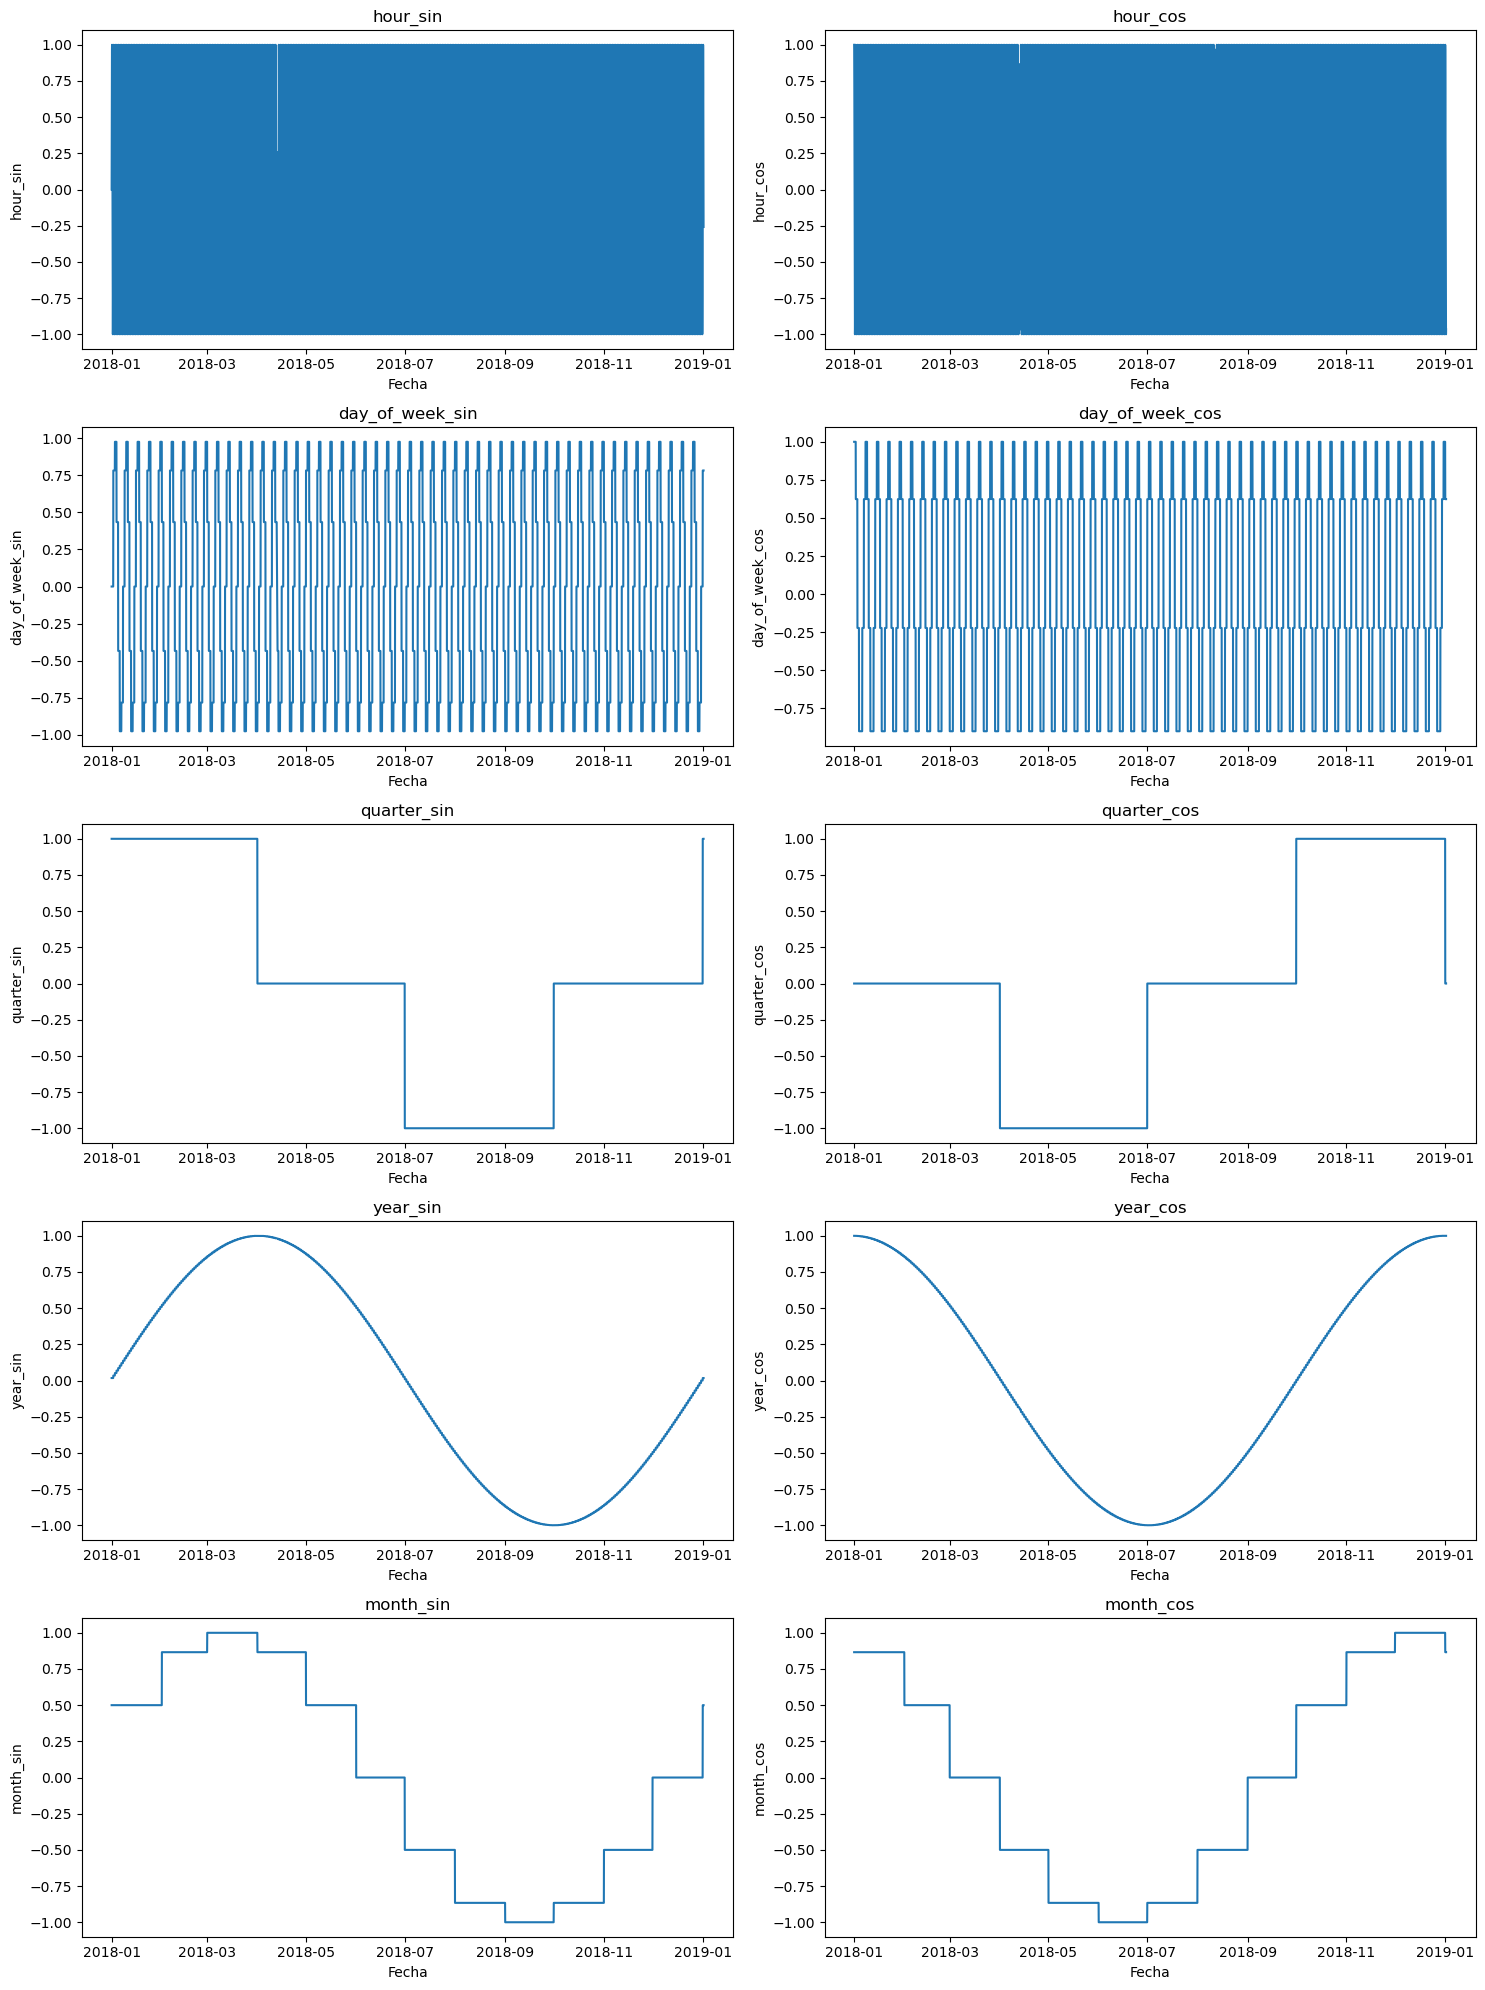

In [18]:
# Crear una figura con 2 subplots de ancho
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

# Lista de columnas a graficar
columnas = ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos', 'year_sin', 'year_cos',  'month_sin', 'month_cos']

# Iterar sobre las columnas y generar los subplots
for i, columna in enumerate(columnas):
  row = i // 2
  col = i % 2
  axes[row, col].plot(data_exogen_AJAHUEL['date'][:8760], data_exogen_AJAHUEL[columna][:8760])
  axes[row, col].set_title(columna)
  axes[row, col].set_xlabel('Fecha')
  axes[row, col].set_ylabel(columna)

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


In [27]:
# Definimos las variables endógenas (consumo) y exógenas (características cíclicas)
endog = data_exogen_AJAHUEL['consumption']

exog = data_exogen_AJAHUEL[['hour_sin','hour_cos','day_of_week_sin','day_of_week_cos', 'year_sin', 'year_cos']]

exog2 = data_exogen_AJAHUEL[['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos', 'year_sin', 'year_cos']]

In [28]:
# Creamos el modelo SARIMAX (ajusta el orden según tus datos)
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit()

c:\Users\schavezh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [253]:
# model = []
# results = []

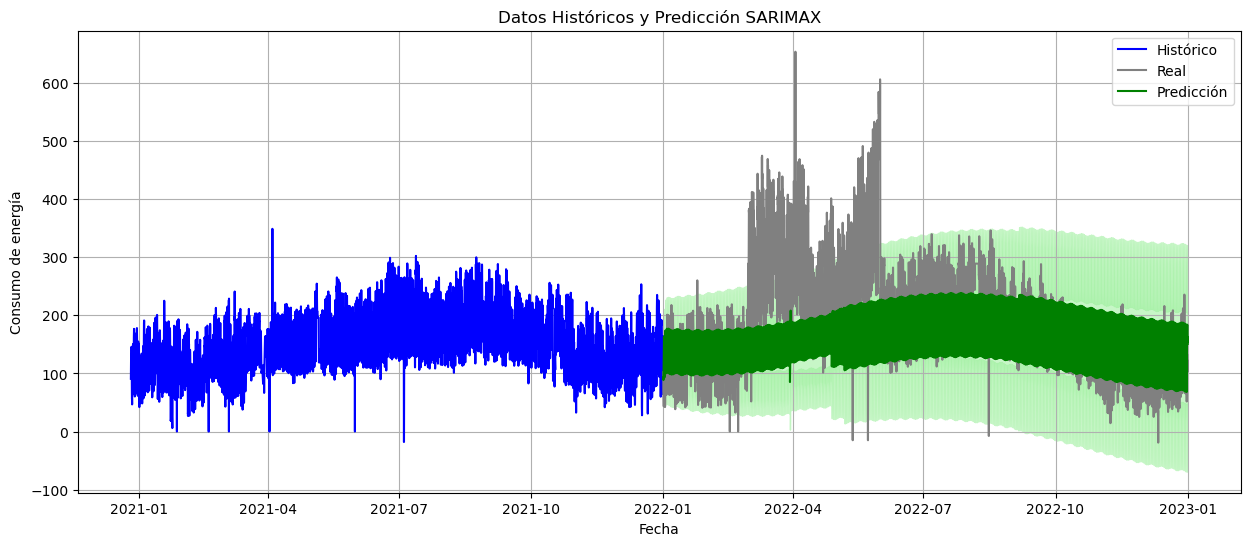

Mean Squared Error (MSE): 8358.144164335281
Root Mean Squared Error (RMSE): 91.422886436249
Mean Absolute Error (MAE): 62.694842998663866
R-squared (R2): 0.05020325274735293


In [224]:
# Predicción: desde el final de los datos históricos hasta 24 pasos en el futuro
n_steps = len(data_test_AJAHUEL)  # Cambia este valor según cuántos pasos en el futuro deseas predecir
pred = results.get_forecast(steps=n_steps, exog=exog.iloc[-n_steps:])

# Obtenemos los intervalos de confianza para las predicciones
pred_ci = pred.conf_int()

# Graficamos los datos históricos
plt.figure(figsize=(15, 6))
plt.plot(data_exogen_AJAHUEL['date'][-n_steps:], data_exogen_AJAHUEL['consumption'][-n_steps:], label='Histórico', color='blue')


# Graficamos los datos reales
plt.plot(data_test_AJAHUEL.index[:n_steps], data_test_AJAHUEL[:n_steps], label='Real', color='gray')

# Graficamos la predicción
pred_index = pd.date_range(start=data_exogen_AJAHUEL['date'].iloc[-1], periods=n_steps+1, freq='h')[1:]
plt.plot(pred_index, pred.predicted_mean, label='Predicción', color='green')

# Graficamos los intervalos de confianza
plt.fill_between(pred_index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='lightgreen', alpha=0.5)

# Etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía')
plt.title('Datos Históricos y Predicción SARIMAX')
plt.legend()

# Mostrar gráfico
plt.grid(True)
plt.show()

# Métricas de evaluación

mse = mean_squared_error(data_test_AJAHUEL[:n_steps], pred.predicted_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(data_test_AJAHUEL[:n_steps], pred.predicted_mean)
mape = mean_absolute_percentage_error(data_test_AJAHUEL[:n_steps], pred.predicted_mean)
r2 = r2_score(data_test_AJAHUEL[:n_steps], pred.predicted_mean)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R2): {r2}")


### --- LSTM

In [34]:
# Preprocesar los datos

# Normalizar los datos para que estén en el rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Aplicamos el escalador al conjunto de entrenamiento
data_AJAHUEL_scaled = scaler.fit_transform(data_AJAHUEL.values.reshape(-1, 1))

# Aplicamos el escalador al conjunto de test
data_test_AJAHUEL_scaled = scaler.transform(data_test_AJAHUEL.values.reshape(-1, 1))


In [42]:
# Convertir los datos a secuencias que LSTM pueda entender
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento (24 horas de historial)
time_steps = 24
X_train, y_train = create_sequences(data_AJAHUEL_scaled, time_steps)

# Crear secuencias para test
X_test, y_test = create_sequences(data_test_AJAHUEL_scaled, time_steps)

# Reshape para que sea compatible con LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [43]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [44]:
# Definir la función de construcción del modelo LSTM con Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Capa de entrada
    model.add(Input(shape=(time_steps, 1)))
    
    # Capas LSTM con hiperparámetros ajustables
    for i in range(hp.Int('num_layers', 1, 3)):  # Ajustar entre 1 y 3 capas LSTM
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=(i < hp.Int('num_layers', 1, 3) - 1)))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
        # Capa de salida
    model.add(Dense(1))
    
    # Compilación del modelo
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')
    
    return model



In [46]:
# Definir el tuner de búsqueda aleatoria
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Minimizar la pérdida de validación
    max_trials=10,  # Realizar hasta 10 configuraciones diferentes
    executions_per_trial=2,  # Ejecutar cada configuración 2 veces
    directory='trial_LSTM_tuning',  # Guardar los resultados en este directorio
    project_name='lstm_tuning'  # Nombre del proyecto
)


In [47]:
# Realizar la búsqueda
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Trial 10 Complete [00h 02m 45s]
val_loss: 0.010668556904420257

Best val_loss So Far: 0.003784328466281295
Total elapsed time: 00h 35m 44s


In [48]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Mostrar el resumen del mejor modelo
best_model.summary()

c:\Users\schavezh\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Entrenar el mejor modelo con más épocas si es necesario
history_tunner = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test[:,:,:], y_test[:]), callbacks=[early_stopping])

Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 4/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0015 - val_loss: 0.0042


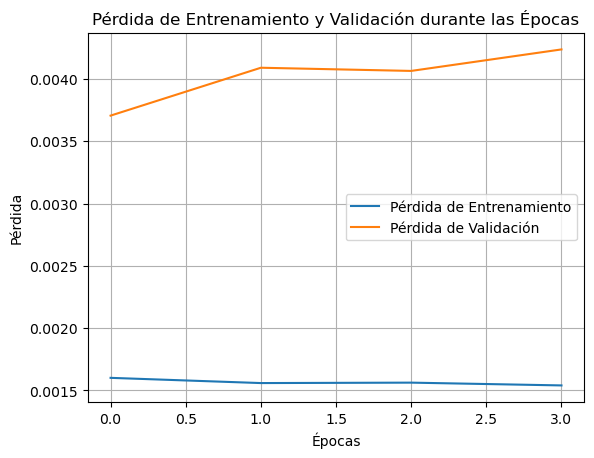

In [51]:
plt.plot(history_tunner.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_tunner.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación durante las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [226]:
# 4. Evaluar el modelo en los datos de test
y_pred_scaled = best_model.predict(X_test[:])

# Invertir la normalización de los valores predichos y reales
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test[:].reshape(-1, 1))

# Calcular el error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calcula las métricas
mse_LSTM = mean_squared_error(y_test_actual, y_pred)
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = mean_absolute_error(y_test_actual, y_pred)
mape_LSTM = mean_absolute_percentage_error(y_test_actual, y_pred)
r2_LSTM = r2_score(y_test_actual, y_pred)

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


Mean Squared Error (MSE): 935.3569472990863
Root Mean Squared Error (RMSE): 30.58360585835304
Mean Absolute Error (MAE): 14.940660011116055
R-squared (R2): 0.9631654694951518


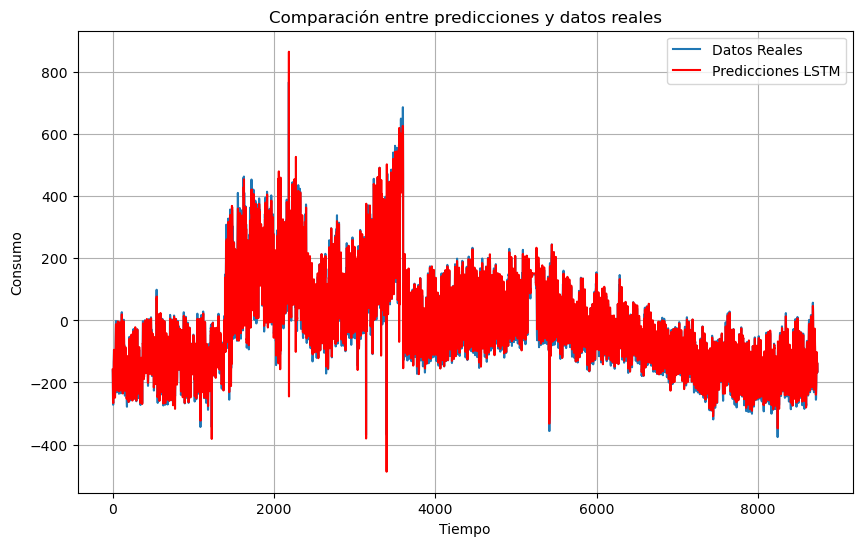

In [227]:
# Imprime las métricas
print(f"Mean Squared Error (MSE): {mse_LSTM}")
print(f"Root Mean Squared Error (RMSE): {rmse_LSTM}")
print(f"Mean Absolute Error (MAE): {mae_LSTM}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_LSTM}")
print(f"R-squared (R2): {r2_LSTM}")
# Opción: Graficar los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Datos Reales')
plt.plot(y_pred, label='Predicciones LSTM', color='red')
plt.title('Comparación entre predicciones y datos reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

## -- SARIMA + LSTM


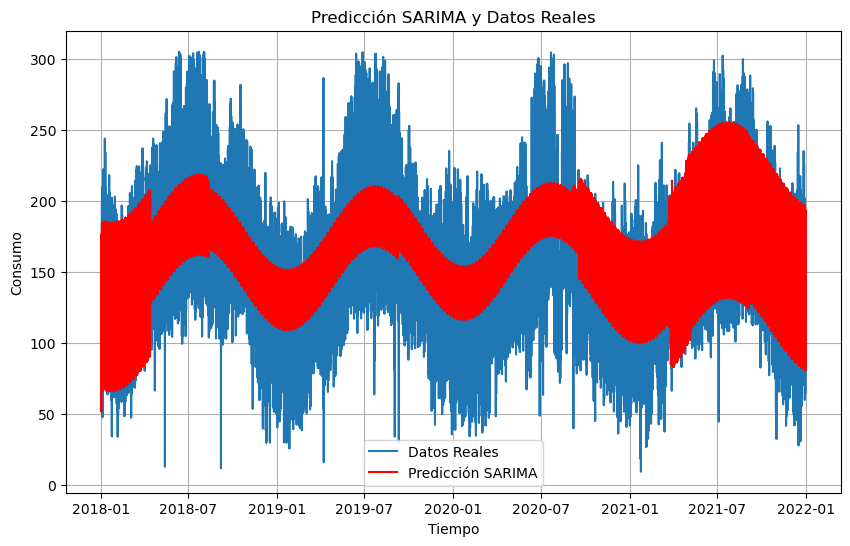

In [156]:
# 3. Calcular los residuos (residuals) para el entrenamiento

sarima_pred_train = results.get_forecast(steps=len(exog), exog=exog.iloc[:])

residuals_train = data_exogen_AJAHUEL['consumption'] - sarima_pred_train.predicted_mean.copy().reset_index(drop=True)

# Para visualización, graficamos las predicciones de SARIMA frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(data_AJAHUEL, label='Datos Reales')
plt.plot(data_exogen_AJAHUEL['date'], sarima_pred_train.predicted_mean , label='Predicción SARIMA', color='red')
#plt.plot(sarima_pred_test, label='Predicción SARIMA', color='green')
plt.title('Predicción SARIMA y Datos Reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

In [157]:
residuals_train

0        29.364181
1        35.352946
2        46.490015
3        48.842080
4        46.635834
           ...    
34908   -31.885604
34909   -60.395845
34910   -57.045963
34911   -39.389263
34912   -48.462097
Length: 34913, dtype: float64

#### LSTM

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [159]:
# Escalar los residuos para que el LSTM funcione mejor
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))

# Función para crear secuencias para el LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo (time_steps)
time_steps = 24  # Usaremos las últimas 24 horas para predecir el próximo valor

# Crear las secuencias de entrenamiento para LSTM
X_train_lstm, y_train_lstm = create_sequences(residuals_train_scaled, time_steps)

# Redimensionar X_train_lstm para que sea compatible con el LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

In [160]:
# 4. Definir el modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(time_steps, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Predecir los residuos
lstm_model.summary()


c:\Users\schavezh\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
# Compilar el modelo
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [162]:
# 3. Entrenar el modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0245 - val_loss: 0.0029
Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0041 - val_loss: 8.4230e-04
Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0024 - val_loss: 8.1384e-04
Epoch 4/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0019 - val_loss: 5.9575e-04
Epoch 5/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0015 - val_loss: 6.0076e-04
Epoch 6/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0012 - val_loss: 5.1589e-04
Epoch 7/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 9.8548e-04 - val_loss: 5.2566e-04
Epoch 8/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.7764e-04 - val_loss: 6.4855e-04
Epoch 9/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.7174e-04 - val_loss: 7.8389e-04


#### Predicciones

In [176]:
data_test_AJAHUEL.copy().reset_index(drop=True) - pred.predicted_mean.copy().reset_index(drop=True)

0        9.196019
1       -7.324258
2      -13.444727
3      -21.502259
4      -31.279300
          ...    
8755   -48.448525
8756   -43.974463
8757   -51.172244
8758   -41.927725
8759   -45.159867
Length: 8760, dtype: float64

In [177]:
# 5. Predecir los residuos en el conjunto de test con LSTM
# Para esto, primero calculamos los residuos del conjunto de test usando SARIMA
residuals_test = data_test_AJAHUEL.copy().reset_index(drop=True) - pred.predicted_mean.copy().reset_index(drop=True)
residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

# Crear secuencias para el conjunto de test
X_test_lstm, _ = create_sequences(residuals_test_scaled, time_steps)

# Predecir los residuos del test
lstm_pred_test_scaled = lstm_model.predict(X_test_lstm)

# Invertir la normalización de los residuos predichos
lstm_pred_test = scaler.inverse_transform(lstm_pred_test_scaled)




273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [220]:
# 6. Calcular la predicción híbrida: SARIMA + LSTM
# Como la predicción de LSTM está sobre los residuos, la predicción final es:
final_pred_test = pred.predicted_mean.copy().reset_index(drop=True)[time_steps:] + lstm_pred_test.flatten()

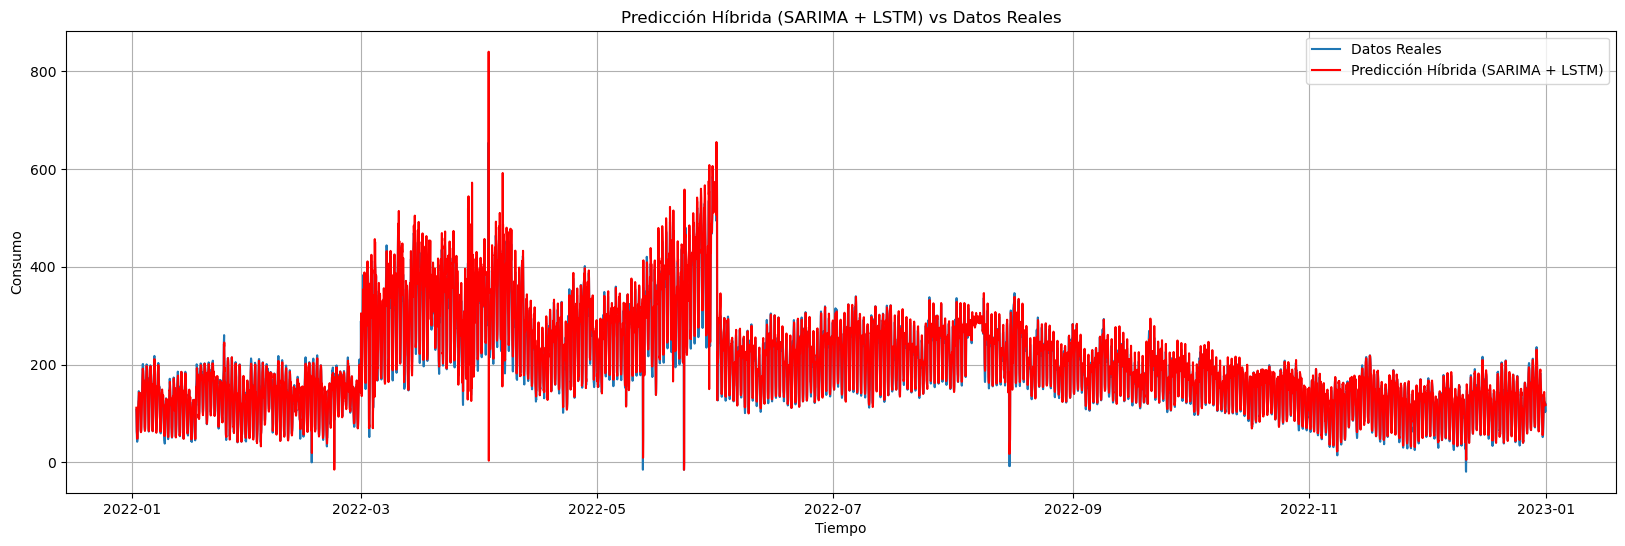

Mean Squared Error (MSE): 405.01440310056364
Root Mean Squared Error (RMSE): 20.124969642227132
Mean Absolute Error (MAE): 9.889273573248307
R-squared (R2): 0.9539123571821307


In [232]:

# Graficar la predicción híbrida frente a los datos reales
plt.figure(figsize=(20, 6))
plt.plot(data_test_AJAHUEL[time_steps:], label='Datos Reales')
plt.plot(data_test_AJAHUEL.index[time_steps:],final_pred_test[:], label='Predicción Híbrida (SARIMA + LSTM)', color='red')
plt.title('Predicción Híbrida (SARIMA + LSTM) vs Datos Reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# Calcula las métricas
mse_SL = mean_squared_error(data_test_AJAHUEL[time_steps:], final_pred_test)
rmse_SL = np.sqrt(mse_SL)
mae_SL = mean_absolute_error(data_test_AJAHUEL[time_steps:], final_pred_test)
mape_SL = mean_absolute_percentage_error(data_test_AJAHUEL[time_steps:], final_pred_test)
r2_SL = r2_score(data_test_AJAHUEL[time_steps:], final_pred_test)

# Imprime las métricas
print(f"Mean Squared Error (MSE): {mse_SL}")
print(f"Root Mean Squared Error (RMSE): {rmse_SL}")
print(f"Mean Absolute Error (MAE): {mae_SL}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape_SL}")
print(f"R-squared (R2): {r2_SL}")

### --- Metricas globales


In [265]:
metricas=pd.DataFrame()

In [266]:
metricas['Metrica']=['MSE','RMSE','MAE','R2']
metricas['SARIMA_24']=[mse_samira_24,rmse_sarimna_24,mae_sarima_24,r2_sarima24]
metricas['SARIMA_48']=[mse_samira_48,rmse_sarimna_48,mae_sarima_48,r2_sarima_48]
metricas['SARIMA_exogen']=[mse,rmse, mae, r2]
metricas['LSTM']=[mse_LSTM,rmse_LSTM,mae_LSTM,r2_LSTM]
metricas['SARIMA_EX_LSTM']=[mse_SL,rmse_SL,mae_SL,r2_SL]

In [267]:
metricas

,Metrica,SARIMA_24,SARIMA_48,SARIMA_exogen,LSTM,SARIMA_EX_LSTM
0,MSE,11043.545975,10999.957693,8358.144164,935.356947,405.014403
1,RMSE,105.088277,104.880683,91.422886,30.583606,20.124970
2,MAE,77.139745,77.009602,62.694843,14.940660,9.889274
3,R2,-0.254888,-0.250005,0.050203,0.963165,0.953912
